In [ ]:
!nvidia-smi

In [ ]:
!pip install -r requirements.txt

# Import packages

In [6]:
import numpy as np
import cv2
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
from google.colab.patches import cv2_imshow

# Preprocess inputs

In [7]:
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])

ToTensor()
 - converts the image with a pixel range of [0, 255] to a PyTorch FloatTensor of shape (C, H, W) with a range [0.0, 1.0]

Normalize() 
- output[channel] = (input[channel] - mean[channel]) / std[channel]

- Normalization helps get data within a range and reduces the skewness which helps learn faster and better. 
- Normalization can also tackle the diminishing and exploding gradients problems.

# Create Dataloaders

- Combines a dataset and a sampler
- Provides an iterable over the given dataset
- The DataLoader supports both map-style and iterable-style datasets - - - Supports with single- or multi-process loading
- Customizing loading order
- Automatic batching

In [8]:
trainset = datasets.MNIST('trainset', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=8, shuffle=True)

6.6%

100.0%


Extracting trainset\MNIST\raw\train-images-idx3-ubyte.gz to trainset\MNIST\raw



100.0%
7.9%

Extracting trainset\MNIST\raw\train-labels-idx1-ubyte.gz to trainset\MNIST\raw



100.0%


Extracting trainset\MNIST\raw\t10k-images-idx3-ubyte.gz to trainset\MNIST\raw



100.0%

Extracting trainset\MNIST\raw\t10k-labels-idx1-ubyte.gz to trainset\MNIST\raw



In [9]:
valset = datasets.MNIST('testset', download=True, train=False, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=8, shuffle=True)

1.3%

100.0%


Extracting testset\MNIST\raw\train-images-idx3-ubyte.gz to testset\MNIST\raw


100.0%


Extracting testset\MNIST\raw\train-labels-idx1-ubyte.gz to testset\MNIST\raw



100.0%
100.0%

Extracting testset\MNIST\raw\t10k-images-idx3-ubyte.gz to testset\MNIST\raw

Extracting testset\MNIST\raw\t10k-labels-idx1-ubyte.gz to testset\MNIST\raw



In [10]:
dataiter = iter(trainloader)

Now that we have an iterator, let's visualize our data

In [11]:
images, labels = dataiter.next()

In [12]:
print(images.shape)
print(labels.shape)

torch.Size([8, 1, 28, 28])
torch.Size([8])


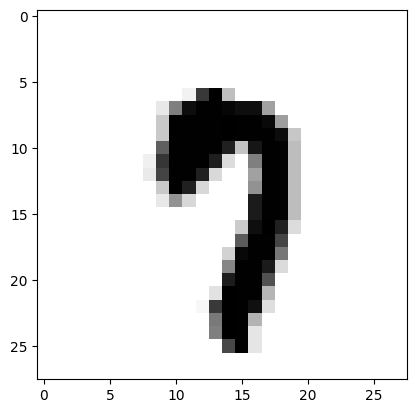

In [13]:
plt.imshow(images[2].numpy().squeeze(), cmap='gray_r')

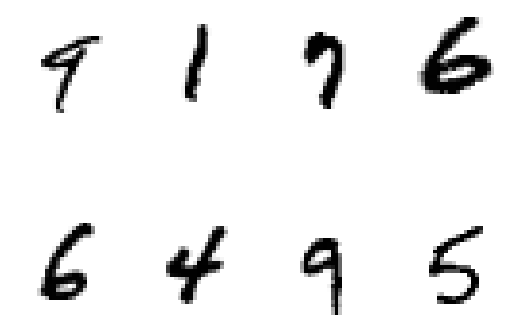

In [14]:
figure = plt.figure()
total_samples = 8
for index in range(1,total_samples+1):
    plt.subplot(2, 4, index)
    plt.axis('off')
    plt.imshow(images[index-1].numpy().squeeze(), cmap='gray_r')

In [15]:
labels

tensor([9, 1, 7, 6, 6, 4, 9, 5])

In [16]:
onehot_labels = nn.functional.one_hot(labels, num_classes=10)

In [17]:
onehot_labels

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]])

# Let's build our DNN

In [18]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))

In [19]:
print(model)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


# Untrained Inference

Lets flatten the images to a 1D array/tensor

In [20]:
model_inputs = images.view(images.shape[0], -1)
model_inputs.shape

torch.Size([8, 784])

In [21]:
pred_probs = model(model_inputs) # probabilities
pred_probs.shape

torch.Size([8, 10])

In [22]:
pred_probs

tensor([[0.0960, 0.0988, 0.1066, 0.1251, 0.1037, 0.1067, 0.0866, 0.0900, 0.1031,
         0.0835],
        [0.0976, 0.0970, 0.1062, 0.1241, 0.1061, 0.1055, 0.0870, 0.0862, 0.1077,
         0.0826],
        [0.1078, 0.0973, 0.1007, 0.1295, 0.1058, 0.1033, 0.0865, 0.0883, 0.0931,
         0.0877],
        [0.1051, 0.0955, 0.1067, 0.1322, 0.1033, 0.1068, 0.0863, 0.0848, 0.0980,
         0.0815],
        [0.0981, 0.0980, 0.1046, 0.1210, 0.1002, 0.1080, 0.0950, 0.0830, 0.0999,
         0.0922],
        [0.1043, 0.0990, 0.1064, 0.1248, 0.1041, 0.1071, 0.0850, 0.0878, 0.1003,
         0.0812],
        [0.1013, 0.0985, 0.0971, 0.1258, 0.1000, 0.1097, 0.0895, 0.0894, 0.0972,
         0.0915],
        [0.1022, 0.0954, 0.1048, 0.1203, 0.1035, 0.1084, 0.0893, 0.0851, 0.1039,
         0.0873]], grad_fn=<SoftmaxBackward0>)

In [23]:
pred_probs.sum(dim=-1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       grad_fn=<SumBackward1>)

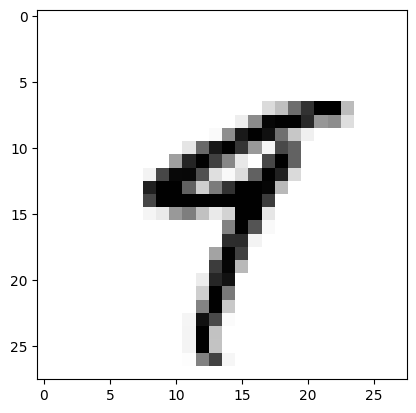

In [24]:
plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

In [25]:
labels[0]

tensor(9)

In [26]:
onehot_labels[0]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [27]:
pred_probs[0]

tensor([0.0960, 0.0988, 0.1066, 0.1251, 0.1037, 0.1067, 0.0866, 0.0900, 0.1031,
        0.0835], grad_fn=<SelectBackward0>)

In [28]:
torch.argmax(pred_probs[0], dim=-1)

tensor(3)

In [29]:
labels

tensor([9, 1, 7, 6, 6, 4, 9, 5])

In [30]:
torch.argmax(pred_probs, dim=0)

tensor([2, 5, 3, 3, 1, 6, 4, 0, 1, 4])

In [31]:
criterion = nn.CrossEntropyLoss()
loss = criterion(pred_probs, labels) #calculate the NLL loss

In [32]:
loss

tensor(2.3084, grad_fn=<NllLossBackward0>)

In [33]:
print('Before backward pass: \n', model[0].weight.grad)
loss.backward()
print('After backward pass: \n', model[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[ 6.5159e-04,  6.5159e-04,  6.5159e-04,  ...,  6.5159e-04,
          6.5159e-04,  6.5159e-04],
        [-1.5553e-03, -1.5553e-03, -1.5553e-03,  ..., -1.5553e-03,
         -1.5553e-03, -1.5553e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-2.6807e-04, -2.6807e-04, -2.6807e-04,  ..., -2.6807e-04,
         -2.6807e-04, -2.6807e-04],
        [-8.6774e-05, -8.6774e-05, -8.6774e-05,  ..., -8.6774e-05,
         -8.6774e-05, -8.6774e-05],
        [-6.0846e-04, -6.0846e-04, -6.0846e-04,  ..., -6.0846e-04,
         -6.0846e-04, -6.0846e-04]])


In [34]:
optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time_init = time()
epochs = 15
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        optimizer.zero_grad()
        
        output = model(images)
        loss = criterion(output, labels)
        
        #This is where the model learns by backpropagating
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time_init)/60)

Epoch 0 - Training loss: 1.8108440079053243
Epoch 1 - Training loss: 1.6352361413637797
Epoch 2 - Training loss: 1.615000259955724
Epoch 3 - Training loss: 1.603326416126887
Epoch 4 - Training loss: 1.5962857864538829
Epoch 5 - Training loss: 1.5921996706644694


In [ ]:
images, labels = next(iter(valloader))

with torch.no_grad():
    pred_probs = model(images.view(images.shape[0], -1))

torch.argmax(pred_probs, dim=-1)

In [ ]:
pred_probs

In [ ]:
print("Predicted Digit =", torch.argmax(pred_probs[0], dim=-1))

In [ ]:
labels

In [ ]:
torch.save(model, './my_mnist_model.pt') 